# Ensemble learning

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [ ]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [ ]:
X = mnist.data[:1000]
y = mnist.target[:1000]

## Transformacja zbioru do przestrzeni 30D

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [28]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(1000, 2)

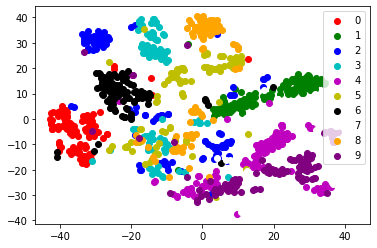

In [29]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
ids = [str(i) for i in range(10)]

for c, label in zip(colors, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [41]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [42]:
X_filtered

array([], shape=(0, 30), dtype=float64)